In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: ______________________
- PRN:  ______________________
- Date: ______________________

# Deep Neural Networks
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [4]:
###-----------------
### Import Libraries
###-----------------
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_label
from utils.configuration import Config

In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'flower_photos'
altName = 'base_model'


EPOCHS = 100
ALPHA = .001
TEST_SIZE = .2
BATCH_SIZE = 32
RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)

In [6]:
data_dir = os.path.join(inpDir, subDir)
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [7]:
IMG_HEIGHT = 188
IMG_WIDTH = 188

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [9]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [10]:
# use f1 score to tune

In [11]:
data_dir = os.path.join(inpDir, subDir)
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [12]:
train_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                seed = RANDOM_STATE,
                                                                subset = 'training',
                                                                validation_split = TEST_SIZE)

test_ds =  tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                seed = RANDOM_STATE,
                                                                subset = 'validation',
                                                                validation_split = TEST_SIZE)
                                                                

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
# is it getting the class names
class_names = train_ds.class_names
num_classes = len(class_names)
display(class_names, num_classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

5

In [14]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

## DATA AUGMENTAION

In [16]:
# def augment(imgs, lbls):
#     random_seed = 24

#     # Define augmentation layers with a fixed seed for deterministic output
#     random_rotation = tf.keras.layers.RandomRotation(0.3, seed=random_seed)  # Random Rotation
#     random_zoom = tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.2), width_factor=(-0.2, -0.2), seed=random_seed)  # Random Zoom
#     random_shift = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=random_seed)  # Random Translation
#     random_flip = tf.keras.layers.RandomFlip("horizontal", seed=random_seed)  # Horizontal Flip
#     brightness = tf.keras.layers.RandomBrightness(0.2, seed=random_seed)  # Random Brightness



#     augmented_image = random_rotation(imgs)
#     augmented_image = random_zoom(augmented_image)
#     augmented_image = random_shift(augmented_image)
#     augmented_image = random_flip(augmented_image)
#     augmented_image = brightness(augmented_image)

#     return augmented_image, lbls

In [17]:
# layer = tf.keras.layers.RandomZoom(height_factor = (-.2, -.2),
#                                     width_factor= (-.2, -.2),
#                                     seed=None,

# )
# plt.figure()

# img_num = 1

# for imgs, lbls in train_ds.take(1):
#     out_image = layer(imgs)
#     plt.subplot(1,2,1)
#     plt.title('Original image')
#     plt.imshow(imgs[img_num].numpy().astype('uint8')) # The method astype('uint8') converts the image data to the uint8 (unsigned 8-bit integer) type.

#     plt.subplot(1, 2, 2)
#     plt.title('zoomed image')
#     plt.imshow(out_image[img_num].numpy().astype('uint8'))

In [18]:
#### PREPROCESSING DATA
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Model

In [20]:
krnl_initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
# krnl_reg = tf.keras.regularizers.L2(l2 = 0.01)
input_shape = (188, 188, 3)

dor1 = .1
dor2 = .2
dor3 = .2
dor4 = .3
dor5 = .3
dor6 = .4
dor7 = .4

inputs = tf.keras.Input(shape = input_shape, name = 'input')

x = tf.keras.layers.Rescaling(1./255.)(inputs)

# conv1

x = tf.keras.layers.Conv2D(32, (3,3),
                           kernel_initializer = krnl_initializer,
                           # kernel_regularizer = krnl_reg,
                           padding = 'same',
                           # activation = tf.keras.activations.relu,
                           name = 'conv_1')(x)  # (188, 188, 32)
# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

# x =tf.keras.layers.Dropout(dor1)(x)
# max pool

x = tf.keras.layers.MaxPool2D((2, 2), (2, 2), name = 'mp_1')(x) #( 94 x 94 x 32)

# conv2

x = tf.keras.layers.Conv2D(64, (3,3),
                           kernel_initializer = krnl_initializer,
                           # kernel_regularizer = krnl_reg,
                           padding = 'valid',
                           # activation = tf.keras.activations.relu,
                           name = 'conv_2')(x)  # (92, 92, 64)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

# x =tf.keras.layers.Dropout(dor2)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_2')(x) #( 46 x 46 x 64) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set3##
 # conv 3
x  = tf.keras.layers.Conv2D(128, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_3')(x) # (44 x 44 x 128)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

# x =tf.keras.layers.Dropout(dor3)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_3')(x) #( 22 x 22 x 128) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set4##
 # conv 4
x  = tf.keras.layers.Conv2D(256, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_4')(x) # (20 x 20 x 256)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

# x =tf.keras.layers.Dropout(dor4)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_4')(x) #( 10 x 10 x 10) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set5##
 # conv 5
x  = tf.keras.layers.Conv2D(512, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_5')(x) # (8 x 8 x 512)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

# x =tf.keras.layers.Dropout(dor5)(x)

# max pool

x = tf.keras.layers.MaxPool2D(name = 'mp_5')(x) #( 4 x 4 x 512) # default filter size is '2 x 2' and default stride is None:- if None then stride will be same as the shape of filter


##set5##
 # conv 5
x  = tf.keras.layers.Conv2D(1024, (3,3), 
                            kernel_initializer = krnl_initializer,
                            # kernel_regularizer = krnl_reg,
                            # activation = tf.keras.activations.relu,
                            name = 'conv_6')(x) # (2 x 2 x 1024)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

# x =tf.keras.layers.Dropout(dor6)(x)


# flattning layer
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, name = 'fc_1',
                          # kernel_regularizer = krnl_reg,
                          # activation = tf.keras.activations.relu
                         )(x)

# batch normalization
x = tf.keras.layers.BatchNormalization()(x)

# activation
x = tf.keras.layers.ReLU()(x)

#Dropout

x =tf.keras.layers.Dropout(dor7)(x)

outputs = tf.keras.layers.Dense(10, name = 'output')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'MNIST')                                                         

In [21]:
model.summary()

Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 188, 188, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 188, 188, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 188, 188, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 188, 188, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 188, 188, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp_1 (MaxPooling2D)             │ (None, 94, 94, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 92, 92, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 92, 92, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 92, 92, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp_2 (MaxPooling2D)             │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 44, 44, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp_3 (MaxPooling2D)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp_4 (MaxPooling2D)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mp_5 (MaxPooling2D)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,822,474 (26.03 MB)

 Trainable params: 6,818,186 (26.01 MB)

 Non-trainable params: 4,288 (16.75 KB)

In [22]:
import numpy as np
from sklearn.utils import class_weight

# Step 1: Extract the labels from the dataset
labels = []
for images, lbls in train_ds:
    labels.extend(lbls.numpy())  # Collect labels from the dataset

# Convert the list of labels into a numpy array
labels = np.array(labels)

# Step 2: Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(labels),  # The unique class labels
    y=labels  # The labels from the dataset
)

# Step 3: Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [23]:
class_weight_dict
# class_weight=class_weight_dict

{0: 1.1910750507099392,
 1: 0.8121715076071923,
 2: 1.1184761904761904,
 3: 1.0467023172905525,
 4: 0.9261829652996846}

In [24]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [25]:
# optimizer = tf.keras.optimizers.SGD(
#     learning_rate=ALPHA,  # Replace ALPHA with the learning rate you want (e.g., 0.01)
#     momentum=0.9,         # Optional: Add momentum for faster convergence (commonly 0.9)
#     nesterov=True        # Optional: Enable Nesterov momentum (set to True if needed)
# )


optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=ALPHA,  # Replace ALPHA with the learning rate you want (e.g., 0.001)
    rho=0.9,              # Decay factor for moving average of squared gradients
    momentum=0.0,         # Optional: Add momentum (default is no momentum)
    epsilon=1e-07,        # Small value to avoid division by zero
    centered=False        # If True, uses centered RMSprop (subtract mean gradient)
)

In [26]:
# optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)
model.compile(optimizer = optimizer, loss = loss_fn, metrics = ['accuracy'], )

In [27]:
epochs = 0
chkptFilePath = os.path.join(modelDir, subDir, f'cnn{epochs}.weights.h5')
PATIENCE = 10
LR_FACTOR= .1
LR_PATIENCE = 5
mcb = tf.keras.callbacks.ModelCheckpoint(chkptFilePath,
                                         monitor = 'val_loss',
                                        verbose = 1,
                                        save_best_only = True,
                                        save_weights_only = True)

escb = tf.keras.callbacks.EarlyStopping(patience = PATIENCE,
                                 verbose =1,
                                 restore_best_weights = True)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(factor = LR_FACTOR,
                                            patience = LR_PATIENCE,
                                            verbose = 1)
                                            

In [28]:
history = model.fit(train_ds, validation_data= test_ds, epochs = EPOCHS, verbose = 2, callbacks = [mcb, escb, lrcb], class_weight=class_weight_dict
                   )

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.97381, saving model to ../models\flower_photos\cnn0.weights.h5
92/92 - 101s - 1s/step - accuracy: 0.5054 - loss: 1.3808 - val_accuracy: 0.3733 - val_loss: 1.9738 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_loss did not improve from 1.97381
92/92 - 88s - 959ms/step - accuracy: 0.6230 - loss: 1.0142 - val_accuracy: 0.3597 - val_loss: 2.5080 - learning_rate: 0.0010
Epoch 3/100

Epoch 3: val_loss improved from 1.97381 to 1.96366, saving model to ../models\flower_photos\cnn0.weights.h5
92/92 - 92s - 996ms/step - accuracy: 0.6856 - loss: 0.8415 - val_accuracy: 0.4005 - val_loss: 1.9637 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_loss improved from 1.96366 to 1.60601, saving model to ../models\flower_photos\cnn0.weights.h5
92/92 - 90s - 976ms/step - accuracy: 0.7245 - loss: 0.7331 - val_accuracy: 0.5531 - val_loss: 1.6060 - learning_rate: 0.0010
Epoch 5/100

Epoch 5: val_loss improved from 1.60601 to 1.27981, saving model to ..

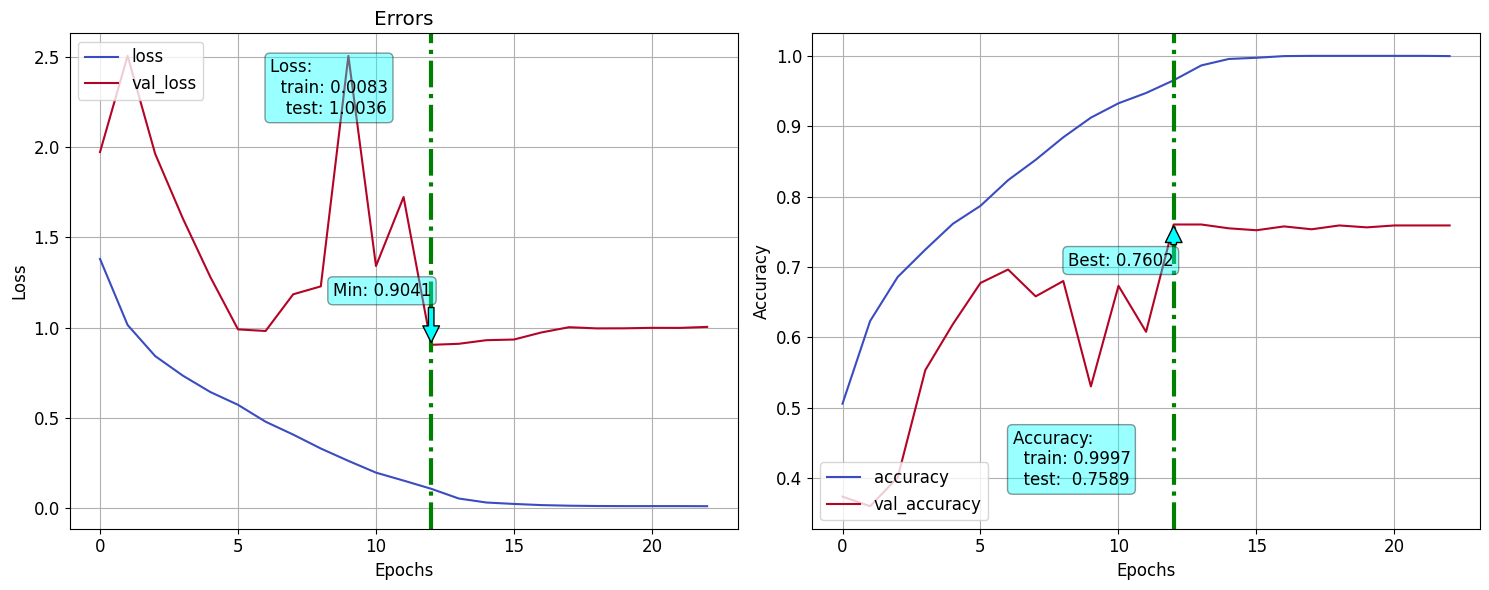

In [29]:
loss_df = pd.DataFrame(history.history)
fn_plot_tf_hist(loss_df)

In [30]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax() # new model (prediction only) = original model+ softmax
    ])
y_true, y_pred = [], []
for feat, lbls in train_ds:
    pred = prediction_model(feat).numpy()
    pred = pred.argmax(axis = 1)
    y_true.extend(lbls)
    y_pred.extend(pred)

len(y_true), len(y_pred)

(2936, 2936)

In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       493
           1       0.98      0.98      0.98       723
           2       0.98      0.98      0.98       525
           3       0.99      0.99      0.99       561
           4       0.99      0.97      0.98       634

    accuracy                           0.98      2936
   macro avg       0.98      0.98      0.98      2936
weighted avg       0.98      0.98      0.98      2936



In [32]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average = "weighted")

0.984327167121363

### Reload best Weights for evaluation

### Evaluate the model

## Validate on the validation set